# In this example, we will rely on `pyjet` for jet clustering.

pyjet: https://github.com/scikit-hep/pyjet

In [1]:
import uproot
import pyjet
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import sys, os
import importlib
import time

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib import cm


## Define the class to fill particle information in to NumpyArray 

### User can use 
```
GenParticles = BrachGenParticles(file)
PID_all = GenParticles.PID
```
### to get all GenParticles PID array
### or
```
GenParticles = BrachGenParticles(file)
PID = GenParticles.PID_At(i)
```
### to get the GenParticles PID array in the ith event

In [2]:
class BrachGenParticles:
    def __init__(self,file):
        self.file = file
        self.length = len(file["Particle.Status"].array())
        self.Status = file["Particle.Status"].array()
        self.PID = file["Particle.PID"].array()
        self.M1 = file["Particle.M1"].array()
        self.M2 = file["Particle.M2"].array()
        self.D1 = file["Particle.D1"].array()
        self.D2  = file["Particle.D2"].array()
        self.PT = file["Particle.PT"].array()
        self.Eta =  file["Particle.Eta"].array()
        self.Phi = file["Particle.Phi"].array()
        self.Mass = file["Particle.Mass"].array()
        self.Labels = ["Status", "PID" , "M1", "M2", "D1", "D2", "PT", "Eta", "Phi", "Mass"]
        
    def length_At(self, i):
        return len(self.Status[i])
    def Status_At(self, i):
        return self.Status[i]
    def PID_At(self, i):
        return self.PID[i]
    def M1_At(self, i):
        return self.M1[i]
    def M2_At(self, i):
        return self.M2[i]
    def D1_At(self, i):
        return self.D1[i]
    def D2_At(self, i):
        return self.D2[i]
    def PT_At(self, i):
        return self.PT[i]
    def Eta_At(self, i):
        return self.Eta[i]
    def Phi_At(self, i):
        return self.Phi[i]
    def Mass_At(self, i):
        return self.Mass[i]
    
class BrachJet:
    def __init__(self,file):
        self.file = file
        self.length = len(file["Jet.PT"].array())
        self.PT = file["Jet.PT"].array()
        self.Eta =  file["Jet.Eta"].array()
        self.Phi = file["Jet.Phi"].array()
        self.Mass = file["Jet.Mass"].array()
        
    def PT_At(self, i):
        return self.PT[i]
    def Eta_At(self, i):
        return self.Eta[i]
    def Phi_At(self, i):
        return self.Phi[i]
    def Mass_At(self, i):
        return self.Mass[i]
    
class Event_Weight:
    def __init__(self,file):
        self.file = file
        self.length = len(file["Event.Weight"].array())
        self.Event_Weight = np.array(file["Event.Weight"].array())
        
    def Event_Weight_At(self, i):
        return self.Event_Weight[i]

## Define Function for Invariant Mass, Transverse Mass

### NOTE: the MT formula here is not compatible with MT in the collider physics, please modify this formula by yourself.

In [3]:
def M(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    return np.sqrt((e1+e2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2)
    
def MT(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    ET1, ET2  = np.sqrt(m1**2 + pt1**2), np.sqrt(m2**2 + pt2**2)
    MT = np.sqrt( (ET1+ET2)**2 - (px1+px2)**2 - (py1+py2)**2 )
    return MT
    
    

## Define Function for Check $r_{inv}$ and Preselection

In [4]:
def Check_r_inv(GenParticle):
    invis_count, vis_count = 0, 0
    Ndark = 0
    for i in range(GenParticle.length):
        for j in range(len(GenParticle.Status_At(i))):
            PID = GenParticle.PID_At(i)[j]
            M1 = GenParticle.M1_At(i)[j]
            M2 = GenParticle.M2_At(i)[j]
            D1 = GenParticle.D1_At(i)[j]
            D2 = GenParticle.D2_At(i)[j]
            status = GenParticle.Status_At(i)[j]
            
            if (abs(PID) == 4900111) and (abs( GenParticle.PID_At(i)[D1]) != 4900111) and (abs( GenParticle.PID_At(i)[D2]) != 4900111):
                if (abs(GenParticle.PID_At(i)[D1]) != 3) and (abs( GenParticle.PID_At(i)[D2]) != 3):
                    invis_count += 1

            if (abs(PID) == 4900111) and (abs( GenParticle.PID_At(i)[D1]) != 4900111) and (abs( GenParticle.PID_At(i)[D2]) != 4900111):
                if (abs( GenParticle.PID_At(i)[D1]) == 3) or (abs( GenParticle.PID_At(i)[D2]) == 3):
                    vis_count += 1

            if (abs(PID) == 4900113) and (abs( GenParticle.PID_At(i)[D1]) != 4900113) and (abs( GenParticle.PID_At(i)[D2]) != 4900113):
                if (abs( GenParticle.PID_At(i)[D1]) > 490000) or (abs( GenParticle.PID_At(i)[D2]) > 490000):
                    invis_count += 1

            if (abs(PID) == 4900113) and (abs( GenParticle.PID_At(i)[D1]) != 4900113) and (abs( GenParticle.PID_At(i)[D2]) != 4900113):
                if (abs( GenParticle.PID_At(i)[D1]) < 6) or (abs( GenParticle.PID_At(i)[D2]) < 6):
                    vis_count += 1

            if (abs(PID) == 4900211) and (status == 1):
                    Ndark += 1

            if (abs(PID) == 4900213) and (status == 1):
                    Ndark += 1
    
    print("There are {} events.".format(len(GenParticle.Status)))
    print("There are Dark meson {}  decay into invisible particle.".format(invis_count))
    print("There are Dark meson {}  decay into visible particle.".format(vis_count))
    print("r_inv = {:^4.4f} ".format(invis_count/(invis_count+vis_count)))
    
    print("There are {} stable Dark mesons.".format(Ndark))
    print("Average = {:^4.4f} ".format(Ndark/len(GenParticle.Status)))
    
    return invis_count/(invis_count+vis_count), Ndark/len(GenParticle.Status)



def Find_xdxd(GenParticle):
    m_xdxd = []
    for i in range(GenParticle.length):
        for j in range(len(GenParticle.Status_At(i))):
            PID = GenParticle.PID_At(i)[j]
            M1 = GenParticle.M1_At(i)[j]
            M2 = GenParticle.M2_At(i)[j]
            D1 = GenParticle.D1_At(i)[j]
            D2 = GenParticle.D2_At(i)[j]
            status = GenParticle.Status_At(i)[j]
            
            if PID == 4900101:
                tmp_1_pt = GenParticle.PT_At(i)[j]
                tmp_1_eta = GenParticle.Eta_At(i)[j]
                tmp_1_phi = GenParticle.Phi_At(i)[j]
                tmp_1_m = GenParticle.Mass_At(i)[j]
#                 print(tmp_1_pt,tmp_1_eta,tmp_1_phi,tmp_1_m)
                break
                
        for j in range(len(GenParticle.Status_At(i))):
            PID = GenParticle.PID_At(i)[j]
            M1 = GenParticle.M1_At(i)[j]
            M2 = GenParticle.M2_At(i)[j]
            D1 = GenParticle.D1_At(i)[j]
            D2 = GenParticle.D2_At(i)[j]
            status = GenParticle.Status_At(i)[j]
            
            
            if PID == -4900101:
                tmp_2_pt = GenParticle.PT_At(i)[j]
                tmp_2_eta = GenParticle.Eta_At(i)[j]
                tmp_2_phi = GenParticle.Phi_At(i)[j]
                tmp_2_m = GenParticle.Mass_At(i)[j]
#                 print(tmp_2_pt,tmp_2_eta,tmp_2_phi,tmp_2_m)
                break
                
                
        m_xdxd.append(M(tmp_1_pt,tmp_1_eta,tmp_1_phi,tmp_1_m,tmp_2_pt,tmp_2_eta,tmp_2_phi,tmp_2_m))
        
    return np.array(m_xdxd)

    
def Preselection(Jet):
    twojet_invariantmass = []
    survived_list = []
    for i in range(Jet.length):
        if len(Jet.PT_At(i)) < 2:
            continue

#         if Jet.PT_At(i)[0] < 440 or Jet.PT_At(i)[1] < 60:
#             continue

#         if np.abs(Jet.Eta_At(i)[0]- Jet.Eta_At(i)[1]) > 1.2:
#             continue

        twojet_invariantmass.append(M(Jet.PT_At(i)[0],Jet.Eta_At(i)[0],Jet.Phi_At(i)[0],Jet.Mass_At(i)[0],
                                      Jet.PT_At(i)[1],Jet.Eta_At(i)[1],Jet.Phi_At(i)[1],Jet.Mass_At(i)[1]))

        survived_list.append(i)

    print("There are {} events.".format(len(twojet_invariantmass)))
    
    return np.array(twojet_invariantmass), np.array(survived_list)

## Import File

In [5]:
path = "/home/MG5_Study_Group/tutorial"
filepath_3_5 = path + "/SVJ_0_03_v2.root"

file_3_5 = uproot.open(filepath_3_5)["Delphes;1"]


#  Print the Branch in the Delphes

In [6]:
# file_3_5.show()

## Load event via class

In [7]:
GenParticle_3_5, Jet_3_5, Event_Weight_3_5 = BrachGenParticles(file_3_5), BrachJet(file_3_5), Event_Weight(file_3_5) 


# Select Stable Final State Particles

#### The `status` of stable final state particles in truth record is `1`.
#### We will loop over each event to build a `event_list` for final state particles.

In [8]:
print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
ticks_1 = time.time()

GenParticle = GenParticle_3_5

event_list = []


for N in range(GenParticle.length):
    
    event_list_tmp = []
    
    for j in range(GenParticle.length_At(N)):
        
        if GenParticle.Status_At(N)[j] == 1: #Stable Final State Particles
            
            event_list_tmp.append([GenParticle.PT_At(N)[j],  GenParticle.Eta_At(N)[j], GenParticle.Phi_At(N)[j], GenParticle.Mass_At(N)[j], GenParticle.PID_At(N)[j]])
            
    event_list_tmp = np.array(event_list_tmp)
    event_list.append(event_list_tmp)

#     if index == 1000:
#         break


print("There are {} events in this event list.".format(len(event_list)))

ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))

Wed Sep 16 01:16:32 2020
There are 10000 events in this event list.
Time Cost : 4.9278 min


# Let's do jet clustering!!
### We use ` np.core.records.fromarrays` to assign the name of kinematic variables and PID
### In `pyjet`, the data type are only 
`
np.dtype([('pT', 'f8'), ('eta', 'f8'), ('phi', 'f8'), ('mass', 'f8')])
`
### or (cluster(..., ep=True))
`
np.dtype([('E', 'f8'), ('px', 'f8'), ('py', 'f8'), ('pz', 'f8')])  
`
### In this example, we use `(pt, eta, phi and mass)`.
### After assigning the name for our each event list, the `pyjet.cluster` and `inclusive_jets` will help us do jet clustering.
`
sequence_cluster = pyjet.cluster(to_cluster, R = 0.4,p = -1)
jets_cluster = sequence_cluster.inclusive_jets(pt_min)
`
#### Variable: `R` is the cone size of the jet.
#### Variable: `p` is the jet clustering algorithm. `-1: anti-kt , 0: Cambridge-Aachen(C/A), 1: kt`
#### Variable: `pt_min` is the minimum jet's pt.



In [16]:
event_list_clustered = []
for i in range(len(event_list)):
    to_cluster = np.core.records.fromarrays(event_list[i].transpose(), 
                                                 names="pT, eta, phi, mass, PID",
                                                 formats = "f8, f8, f8, f8, f8")
    pt_min = 200
    sequence_cluster = pyjet.cluster(to_cluster, R = 0.6, p = -1) # p = -1: anti-kt , 0: Cambridge-Aachen(C/A), 1: kt
    jets_cluster = sequence_cluster.inclusive_jets(pt_min)
    event_list_clustered.append(jets_cluster)


# Print jets in the Nth event

In [17]:
N = 0

for i, jets in enumerate(event_list_clustered[N]):
    print("{}".format("No." +str(i)+" Jet's Information"))
    print(jets)
    print("-------------------------------------------------------------------------")
    print("{:^19} {:^20} ".format("Constituent's PID","Constituent's Four Momentum"))
    print("-------------------------------------------------------------------------")
    
    for constituent in jets: # get constituent in each "jet_element"
        print("{:^19} {} ".format(int(constituent.PID), constituent))
    print("-------------------------------------------------------------------------")

No.0 Jet's Information
PseudoJet(pt=604.553, eta=-0.064, phi=-1.720, mass=184.148)
-------------------------------------------------------------------------
 Constituent's PID  Constituent's Four Momentum 
-------------------------------------------------------------------------
        211         PseudoJet(pt=4.461, eta=-0.469, phi=-2.125, mass=0.140) 
        211         PseudoJet(pt=1.569, eta=-0.390, phi=-2.186, mass=0.140) 
       -321         PseudoJet(pt=1.444, eta=0.148, phi=-2.255, mass=0.494) 
        211         PseudoJet(pt=0.595, eta=0.270, phi=-1.251, mass=0.140) 
        22          PseudoJet(pt=0.395, eta=-0.162, phi=-2.263, mass=0.000) 
        22          PseudoJet(pt=0.172, eta=-0.036, phi=-2.262, mass=0.000) 
        211         PseudoJet(pt=1.424, eta=0.480, phi=-1.714, mass=0.140) 
        14          PseudoJet(pt=0.511, eta=0.350, phi=-2.048, mass=0.000) 
        22          PseudoJet(pt=1.049, eta=-0.571, phi=-1.673, mass=-0.000) 
        321         PseudoJet(

# Print the Truth Record in an Event

In [ ]:
GenParticle = GenParticle_3_5
# GenParticle = GenParticle_ppzjj
print("There are {} information in this event.".format(len(GenParticle.Status[0])))
print("GenParticle Information")
print("{:^5}{:^7}{:^7}{:^7}{:^7}{:^7}{:^7}{:^8}{:^8}{:^8}{:^8}".format("#","Status","PID", "M1", "M2", "D1", "D2", "PT", "Eta","Phi", "Mass"))

index = 0 ## which event you want to print out

for j in range(len(GenParticle.Status_At(index))):
    
    if GenParticle.Status_At(index)[j] == 1: ##Selet the Stable Final State Particles

        print("{:^5}{:^7}{:^7}{:^7}{:^7}{:^7}{:^7}{:^8.5}{:^8.5}{:^8.5}{:^8.5}".format( \
        j, GenParticle.Status_At(index)[j],  GenParticle.PID_At(index)[j], GenParticle.M1_At(index)[j], GenParticle.M2_At(index)[j],
         GenParticle.D1_At(index)[j], GenParticle.D2_At(index)[j],  GenParticle.PT_At(index)[j],  GenParticle.Eta_At(index)[j], GenParticle.Phi_At(index)[j], GenParticle.Mass_At(index)[j]))



## Findin the first two Xd(`4900101`) and $\bar{\mathrm{Xd}}$(`-4900101`) in the truth record table for invariant mass calculation.

In [11]:
m_dxdx = Find_xdxd(GenParticle_3_5)

# Calculate di-jet Inavariant Mass from Detector Simulation

In [12]:
dijet_invariantmass, survived_list = Preselection(Jet_3_5)

There are 895 events.


## Calculate the number of event for event weight 
## Luminosity $\mathcal{L}$  = 37 $fb^{-1}$

In [13]:
weight_03_5 = Event_Weight_3_5.Event_Weight/10000

# Di-Jet Events' Selection From Truth Record
### We want to compare the inavriant mass distribution between two reconstructed jets and two dark quarks.
### We need select the events with # of jet >=2.

In [19]:
M_JJ = []
event_sele = []
for N in range(len(event_list_clustered)):
    
    if len(event_list_clustered[N]) >= 2: # at least two jets in this event.
        jet_1 = event_list_clustered[N][0] #leading jet's information
        jet_2 = event_list_clustered[N][1] #subleading jet's information
        
        M_JJ.append( M(jet_1.pt,jet_1.eta,jet_1.phi,jet_1.mass,jet_2.pt,jet_2.eta,jet_2.phi,jet_2.mass))
        event_sele.append(N)
        
print("There are {} events passed this di-jet selection.".format(len(M_JJ)))

There are 9136 events passed this di-jet selection.


## Example 1: Plot in differential number of event

total events: 10000 


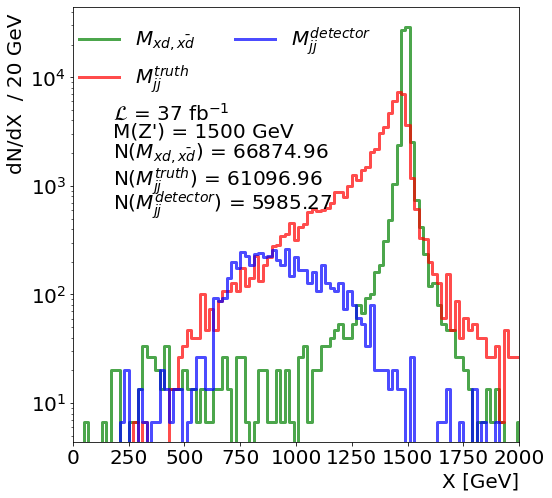

In [71]:
plt.figure(figsize=(8,8)) # plotsize

print("total events: {} ".format(len(m_dxdx)))

bin_size = np.linspace(0,5000,251)

hist, bins = np.histogram(m_dxdx, bins=bin_size, weights = weight_03_5*37*1000)
plt.step(bins[:-1], hist.astype(np.float32),color = "green", where='mid',linewidth=3, alpha=0.7,label="$M_{xd,\\bar{xd}}$") 

hist_M_JJ, bins_M_JJ = np.histogram(M_JJ, bins=bin_size, weights = weight_03_5[event_sele]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ.astype(np.float32), color = "red", where='mid',linewidth=3, alpha=0.7,label="$M^{truth}_{jj}$") 

hist_M_JJ_detec, bins_M_JJ_detec = np.histogram(dijet_invariantmass, bins=bin_size, weights = weight_03_5[survived_list]*37*1000)
plt.step(bins_M_JJ_detec[:-1], hist_M_JJ_detec.astype(np.float32), color = "blue", where='mid',linewidth=3, alpha=0.7,label="$M^{detector}_{jj}$") 



plt.text(180, 4000, "$\mathcal{L}$ = 37 $\mathrm{fb}^{-1}$", fontsize=20)
plt.text(180, 2800, "M(Z') = 1500 GeV", fontsize=20)
plt.text(180, 1800, "N($M_{xd,\\bar{xd}}$) = " + str(np.round(np.sum(hist.astype(np.float32)),2)), fontsize=20)
plt.text(180, 1000, "N($M^{truth}_{jj}$) = " + str(np.round(np.sum(hist_M_JJ.astype(np.float32)),2)), fontsize=20)
plt.text(180, 600, "N($M^{detector}_{jj}$) = " + str(np.round(np.sum(hist_M_JJ_detec.astype(np.float32)),2)), fontsize=20)



plt.legend(bbox_to_anchor=(0.71, 1),ncol=2,fontsize=20,frameon=False)
# plt.legend(ncol=2,fontsize=25)# plot label tag
plt.yscale('log') 
# plt.xscale('log') 
plt.xlabel("X [GeV]" , fontsize=20, horizontalalignment='right',x=1)  # plot x-axis label
plt.ylabel("dN/dX  / 20 GeV ", fontsize=20, horizontalalignment='right',y=1)  # plot y-axis label
plt.xticks(fontsize=20)   # set x-ticks size
plt.yticks(fontsize=20)   # set y-ticks size 
plt.xlim((0,2000))
# plt.ylim((10,3000))
# plt.savefig("./invariant_mass_SVJ.png")  #save figure as png
plt.show()

##### Example 2: Plot in normalized to one

total events: 10000 


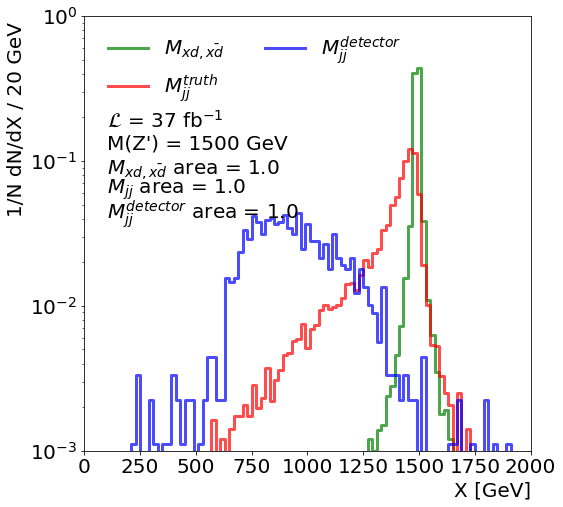

In [86]:
plt.figure(figsize=(8,8)) # plotsize

print("total events: {} ".format(len(m_dxdx)))

bin_size = np.linspace(0,5000,251)

hist, bins = np.histogram(m_dxdx, bins=bin_size, weights = weight_03_5)
plt.step(bins[:-1], hist.astype(np.float32)/np.sum(hist),color = "green", where='mid',linewidth=3, alpha=0.7,label="$M_{xd,\\bar{xd}}$") 


hist_M_JJ, bins_M_JJ = np.histogram(M_JJ, bins=bin_size, weights = weight_03_5[event_sele]*37*1000)
plt.step(bins_M_JJ[:-1], hist_M_JJ.astype(np.float32)/np.sum(hist_M_JJ), color = "red", where='mid',linewidth=3, alpha=0.7,label="$M^{truth}_{jj}$") 

hist_M_JJ_detec, bins_M_JJ_detec = np.histogram(dijet_invariantmass, bins=bin_size, weights = weight_03_5[survived_list]*37*1000)
plt.step(bins_M_JJ_detec[:-1], hist_M_JJ_detec.astype(np.float32)/np.sum(hist_M_JJ_detec), color = "blue", where='mid',linewidth=3, alpha=0.7,label="$M^{detector}_{jj}$") 





plt.text(100, 0.17, "$\mathcal{L}$ = 37 $\mathrm{fb}^{-1}$", fontsize=20)
plt.text(100, 0.12, "M(Z') = 1500 GeV", fontsize=20)
plt.text(100, 0.08, "$M_{xd,\\bar{xd}}$ area = " + str(np.round(np.sum(hist.astype(np.float32)/np.sum(hist)),2)), fontsize=20)
plt.text(100, 0.06, "$M_{jj}$ area = " + str(np.round(np.sum(hist_M_JJ.astype(np.float32))/np.sum(hist_M_JJ),2)[0]), fontsize=20)
plt.text(100, 0.04, "$M^{detector}_{jj}$ area = " + str(np.round(np.sum(hist_M_JJ_detec.astype(np.float32))/np.sum(hist_M_JJ_detec),2)[0]), fontsize=20)





plt.legend(bbox_to_anchor=(0.75, 1),ncol=2,fontsize=20,frameon=False)
# plt.legend(ncol=2,fontsize=25)# plot label tag
plt.yscale('log') 
# plt.xscale('log') 
plt.xlabel("X [GeV]" , fontsize=20, horizontalalignment='right',x=1)  # plot x-axis label
plt.ylabel("1/N dN/dX / 20 GeV ", fontsize=20, horizontalalignment='right',y=1)  # plot y-axis label
plt.xticks(fontsize=20)   # set x-ticks size
plt.yticks(fontsize=20)   # set y-ticks size 
plt.xlim((0,2000))
plt.ylim((0.001,1))
# plt.savefig("./invariant_mass_SVJ.pdf")  #save figure as pdf
plt.show()

## Example 3: Plot in differential cross section
### Please check that the area under the curve is total cross section.
 

total events: 10000 


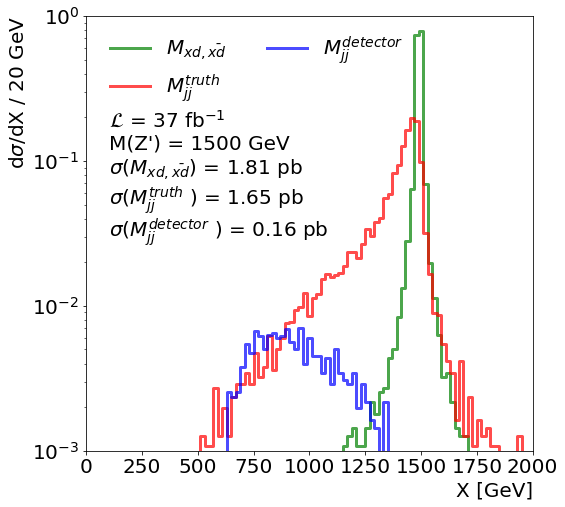

In [85]:
plt.figure(figsize=(8,8)) # plotsize

print("total events: {} ".format(len(m_dxdx)))

bin_size = np.linspace(0,5000,251)

hist, bins = np.histogram(m_dxdx, bins=bin_size, weights = weight_03_5)
plt.step(bins[:-1], hist.astype(np.float32),color = "green", where='mid',linewidth=3, alpha=0.7,label="$M_{xd,\\bar{xd}}$") 

hist_M_JJ, bins_M_JJ = np.histogram(M_JJ, bins=bin_size, weights = weight_03_5[event_sele])
plt.step(bins_M_JJ[:-1], hist_M_JJ.astype(np.float32), color = "red", where='mid',linewidth=3, alpha=0.7,label="$M^{truth}_{jj}$") 

hist_M_JJ_detec, bins_M_JJ_detec = np.histogram(dijet_invariantmass, bins=bin_size, weights = weight_03_5[survived_list])
plt.step(bins_M_JJ_detec[:-1], hist_M_JJ_detec.astype(np.float32), color = "blue", where='mid',linewidth=3, alpha=0.7,label="$M^{detector}_{jj}$") 


plt.text(100, 0.17 , "$\mathcal{L}$ = 37 $\mathrm{fb}^{-1}$", fontsize=20)
plt.text(100, 0.12, "M(Z') = 1500 GeV", fontsize=20)
plt.text(100, 0.08, "$\sigma$($M_{xd,\\bar{xd}}$) = " + str(np.round(np.sum(hist)[0],2)) + " pb", fontsize=20)
plt.text(100, 0.05, "$\sigma$($M^{truth}_{jj}$ ) = " + str(np.round(np.sum(hist_M_JJ)[0],2))+ " pb", fontsize=20)
plt.text(100, 0.03, "$\sigma$($M^{detector}_{jj}$ ) = " + str(np.round(np.sum(hist_M_JJ_detec)[0],2))+ " pb", fontsize=20)



plt.legend(bbox_to_anchor=(0.75, 1),ncol=2,fontsize=20,frameon=False)
# plt.legend(ncol=2,fontsize=25)# plot label tag
plt.yscale('log') 
# plt.xscale('log') 
plt.xlabel("X [GeV]" , fontsize=20, horizontalalignment='right',x=1)  # plot x-axis label
plt.ylabel("d$\sigma$/dX / 20 GeV ", fontsize=20, horizontalalignment='right',y=1)  # plot y-axis label
plt.xticks(fontsize=20)   # set x-ticks size
plt.yticks(fontsize=20)   # set y-ticks size 
plt.xlim((0,2000))
plt.ylim((0.001,1))
# plt.savefig("./invariant_mass_SVJ.pdf")  #save figure as pdf
plt.show()

## Check the $r_{inv}$

In [50]:
Check_r_inv(GenParticle_3_5)


There are 14860 events.
There are Dark meson 29205  decay into invisible particle.
There are Dark meson 67733  decay into visible particle.
r_inv = 0.3013 
There are 58410 stable Dark mesons.
Average = 3.9307 


(0.3012750417792816, 3.930686406460296)

In [13]:
Lambda_d = [1,5,10,50,100,150,200,250,300,350]
for i, lambda_d in enumerate(Lambda_d):
    print("lambda: {:^7.3f}  alpha:{:^7.3f}".format(Lambda_d[i],np.pi*2/((11./3.*2-2./3.*2)*np.log(1000./lambda_d))))


lambda:  1.000   alpha: 0.152 
lambda:  5.000   alpha: 0.198 
lambda: 10.000   alpha: 0.227 
lambda: 50.000   alpha: 0.350 
lambda: 100.000  alpha: 0.455 
lambda: 150.000  alpha: 0.552 
lambda: 200.000  alpha: 0.651 
lambda: 250.000  alpha: 0.755 
lambda: 300.000  alpha: 0.870 
lambda: 350.000  alpha: 0.997 
